In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np


In [2]:
#256x256 rule of thumb
INPUT_SIZE = (256,256,3)
EPOCHS = 100
OPTIMIZER = keras.optimizers.Adam()
LOSS = 'categorical_crossentropy' 

In [3]:
#Base model: vgg16
base_model = keras.applications.VGG16(
    weights = "imagenet",  # Load weights pre-trained on ImageNet.
    input_shape = INPUT_SIZE,
    include_top=False,
)  # Do not include the ImageNet classifier at the top.
base_model.trainable = False
print(type(base_model))
base_model.summary() #Note the bracket here as well. It is not an issue. 

<class 'keras.engine.functional.Functional'>
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (Ma

In [4]:
train_ds = keras.utils.image_dataset_from_directory(
    '/home/sawaiz/Documents/fyp/Datasets/FEI dataset/FEI SPLIT V2/Training',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size= 32,
    image_size= INPUT_SIZE[:2],
)
validation_ds = keras.utils.image_dataset_from_directory(
    '/home/sawaiz/Documents/fyp/Datasets/FEI dataset/FEI SPLIT V2/Validation',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size= 32,
    image_size= INPUT_SIZE[:2],
)
test_ds = keras.utils.image_dataset_from_directory(
    '/home/sawaiz/Documents/fyp/Datasets/FEI dataset/FEI SPLIT V2/Testing',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size= 32,
    image_size= INPUT_SIZE[:2],
)


Found 800 files belonging to 200 classes.
Found 800 files belonging to 200 classes.
Found 1200 files belonging to 200 classes.


In [5]:
from keras import Sequential
#Data augmentation: Using them as preprocessing layers. these are like creating function
random_flip = keras.layers.RandomFlip("horizontal")
random_rotation = keras.layers.RandomRotation(
    factor = 0.1,
    fill_mode = 'nearest',
    interpolation = 'bilinear',                                                  
)
random_translation = keras.layers.RandomRotation(
    factor = 0.35,
    fill_mode='nearest',
    interpolation='bilinear',
)
random_contrast = keras.layers.RandomContrast(0.7)
random_brightness = keras.layers.RandomBrightness(0.4)

scale_layer = keras.layers.Rescaling(scale = 1/127.5, offset = -1) #-1 to 1 scale
reshape = keras.layers.Reshape((256,256.3))

#Apply preprocessing functions on the inputs
inputs = keras.Input(shape=INPUT_SIZE)
x = random_flip(inputs)
x = random_rotation(x)
x = random_brightness(x)
x = random_translation(x)
x = random_contrast(x)
x = scale_layer(x)

#Connect the base model: VGG16
outputs = base_model(x, training = False)
outputs = keras.layers.GlobalAveragePooling2D()(outputs) #can use flatten as well.
outputs = keras.layers.Dropout(0.5)(outputs)
outputs = keras.layers.Dense(200, activation = 'softmax')(outputs)

model = keras.Model(inputs, outputs)
model.summary()
    
#for layer in model.layers:
#    print(layer.output_shape)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 random_brightness (RandomBr  (None, 256, 256, 3)      0         
 ightness)                                                       
                                                                 
 random_rotation_1 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                             

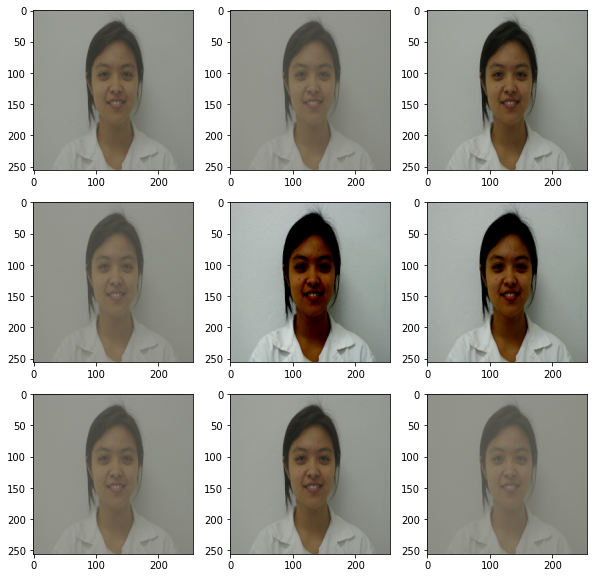

In [6]:
#Effects of different augmentations are tested
import numpy as np
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = random_contrast(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))


In [7]:
#Model compilation
model.compile(
    optimizer = OPTIMIZER,
    loss = LOSS,
    metrics = ['accuracy']
)

In [8]:
history = model.fit(train_ds, epochs = EPOCHS, validation_data = validation_ds)

Epoch 1/100
25/25 [==============================] - 23s 405ms/step - loss: 5.6890 - accuracy: 0.0037 - val_loss: 5.4010 - val_accuracy: 0.0050
Epoch 2/100
25/25 [==============================] - 10s 401ms/step - loss: 5.5025 - accuracy: 0.0037 - val_loss: 5.3069 - val_accuracy: 0.0125
Epoch 3/100
25/25 [==============================] - 10s 401ms/step - loss: 5.4401 - accuracy: 0.0075 - val_loss: 5.2546 - val_accuracy: 0.0162
Epoch 4/100
25/25 [==============================] - 10s 404ms/step - loss: 5.3919 - accuracy: 0.0037 - val_loss: 5.2215 - val_accuracy: 0.0350
Epoch 5/100
25/25 [==============================] - 10s 401ms/step - loss: 5.3547 - accuracy: 0.0113 - val_loss: 5.1937 - val_accuracy: 0.0437
Epoch 6/100
25/25 [==============================] - 10s 407ms/step - loss: 5.3202 - accuracy: 0.0088 - val_loss: 5.1681 - val_accuracy: 0.0500
Epoch 7/100
25/25 [==============================] - 10s 401ms/step - loss: 5.3026 - accuracy: 0.0075 - val_loss: 5.1443 - val_accuracy:

Epoch 24/100
25/25 [==============================] - 10s 405ms/step - loss: 4.9607 - accuracy: 0.0562 - val_loss: 4.7937 - val_accuracy: 0.1675
Epoch 25/100
25/25 [==============================] - 10s 402ms/step - loss: 4.9023 - accuracy: 0.0575 - val_loss: 4.7771 - val_accuracy: 0.1762
Epoch 26/100
25/25 [==============================] - 10s 404ms/step - loss: 4.8864 - accuracy: 0.0700 - val_loss: 4.7564 - val_accuracy: 0.1937
Epoch 27/100
25/25 [==============================] - 10s 403ms/step - loss: 4.8896 - accuracy: 0.0725 - val_loss: 4.7367 - val_accuracy: 0.1863
Epoch 28/100
25/25 [==============================] - 10s 421ms/step - loss: 4.8992 - accuracy: 0.0725 - val_loss: 4.7201 - val_accuracy: 0.1825
Epoch 29/100
25/25 [==============================] - 10s 412ms/step - loss: 4.8713 - accuracy: 0.0887 - val_loss: 4.7001 - val_accuracy: 0.1838
Epoch 30/100
25/25 [==============================] - 10s 413ms/step - loss: 4.8631 - accuracy: 0.0812 - val_loss: 4.6833 - val_ac

25/25 [==============================] - 10s 401ms/step - loss: 4.2077 - accuracy: 0.2825 - val_loss: 3.9476 - val_accuracy: 0.4475
Epoch 81/100
25/25 [==============================] - 10s 403ms/step - loss: 4.2183 - accuracy: 0.2875 - val_loss: 3.9343 - val_accuracy: 0.4437
Epoch 82/100
25/25 [==============================] - 10s 404ms/step - loss: 4.1895 - accuracy: 0.2700 - val_loss: 3.9202 - val_accuracy: 0.4850
Epoch 83/100
25/25 [==============================] - 10s 402ms/step - loss: 4.1930 - accuracy: 0.2612 - val_loss: 3.9068 - val_accuracy: 0.4725
Epoch 84/100
25/25 [==============================] - 10s 401ms/step - loss: 4.1711 - accuracy: 0.2937 - val_loss: 3.8952 - val_accuracy: 0.4613
Epoch 85/100
25/25 [==============================] - 10s 401ms/step - loss: 4.1715 - accuracy: 0.2900 - val_loss: 3.8807 - val_accuracy: 0.4787
Epoch 86/100
25/25 [==============================] - 10s 402ms/step - loss: 4.1684 - accuracy: 0.2663 - val_loss: 3.8707 - val_accuracy: 0.466

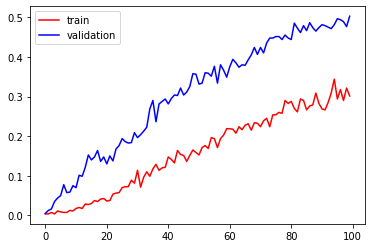

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], color = 'red', label ='train')
plt.plot(history.history['val_accuracy'], color = 'blue', label ='validation')
plt.legend()
plt.show()

In [14]:
history_2 = model.fit(train_ds, epochs = EPOCHS, validation_data = validation_ds)

Epoch 1/100
25/25 [==============================] - 10s 400ms/step - loss: 4.0242 - accuracy: 0.3075 - val_loss: 3.7023 - val_accuracy: 0.4925
Epoch 2/100
25/25 [==============================] - 10s 401ms/step - loss: 4.0126 - accuracy: 0.3113 - val_loss: 3.6875 - val_accuracy: 0.5050
Epoch 3/100
25/25 [==============================] - 10s 402ms/step - loss: 4.0223 - accuracy: 0.3125 - val_loss: 3.6739 - val_accuracy: 0.5288
Epoch 4/100
25/25 [==============================] - 10s 404ms/step - loss: 4.0180 - accuracy: 0.3237 - val_loss: 3.6633 - val_accuracy: 0.5288
Epoch 5/100
25/25 [==============================] - 10s 404ms/step - loss: 3.9502 - accuracy: 0.3487 - val_loss: 3.6532 - val_accuracy: 0.5250
Epoch 6/100
25/25 [==============================] - 10s 402ms/step - loss: 3.9579 - accuracy: 0.3638 - val_loss: 3.6461 - val_accuracy: 0.5288
Epoch 7/100
25/25 [==============================] - 10s 403ms/step - loss: 3.9779 - accuracy: 0.3450 - val_loss: 3.6344 - val_accuracy:

25/25 [==============================] - 10s 402ms/step - loss: 3.6183 - accuracy: 0.3913 - val_loss: 3.1521 - val_accuracy: 0.6225
Epoch 58/100
25/25 [==============================] - 10s 403ms/step - loss: 3.6199 - accuracy: 0.3812 - val_loss: 3.1424 - val_accuracy: 0.6438
Epoch 59/100
25/25 [==============================] - 10s 401ms/step - loss: 3.5926 - accuracy: 0.3900 - val_loss: 3.1339 - val_accuracy: 0.6363
Epoch 60/100
25/25 [==============================] - 10s 404ms/step - loss: 3.5996 - accuracy: 0.4000 - val_loss: 3.1302 - val_accuracy: 0.6288
Epoch 61/100
25/25 [==============================] - 10s 405ms/step - loss: 3.6325 - accuracy: 0.3750 - val_loss: 3.1191 - val_accuracy: 0.6587
Epoch 62/100
25/25 [==============================] - 10s 402ms/step - loss: 3.5752 - accuracy: 0.4013 - val_loss: 3.1117 - val_accuracy: 0.6500
Epoch 63/100
25/25 [==============================] - 10s 401ms/step - loss: 3.6040 - accuracy: 0.4050 - val_loss: 3.1044 - val_accuracy: 0.663

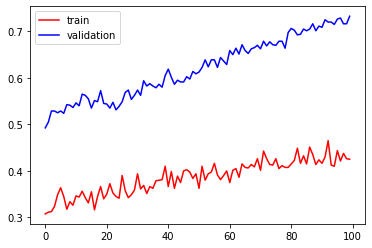

In [16]:
import matplotlib.pyplot as plt
plt.plot(history_2.history['accuracy'], color = 'red', label ='train')
plt.plot(history_2.history['val_accuracy'], color = 'blue', label ='validation')
plt.legend()
plt.show()

In [ ]:
#model.fit(validation_ds, epochs = 100, validation_data = validation_ds)

In [17]:
results_test = model.evaluate(test_ds)

38/38 [==============================] - 10s 271ms/step - loss: 3.4573 - accuracy: 0.4067


In [19]:
results_train = model.evaluate(train_ds) #Train without augmented images

25/25 [==============================] - 4s 160ms/step - loss: 2.7295 - accuracy: 0.8188


In [20]:
results_validation = model.evaluate(validation_ds)

25/25 [==============================] - 4s 159ms/step - loss: 2.8127 - accuracy: 0.7325


In [18]:
model.save('model results/Vgg16 V2 200 epochs')

INFO:tensorflow:Assets written to: model results/Vgg16 V2 200 epochs/assets


INFO:tensorflow:Assets written to: model results/Vgg16 V2 200 epochs/assets
